## __Solving Unsteady Darcy Equations__

### Problem Statement

In this tutorial, we will simulate **unsteady flow** in a fractured rock system, solving the Darcy equation at multiple time steps. Unlike steady-state flow, where conditions remain constant over time, unsteady flow evolves as hydraulic heads and flow rates change with time. This is critical for understanding time-dependent processes such as fluid injection, extraction, and groundwater recharge.

The rock matrix in this example is assumed to be **impervious**, meaning flow occurs only within the fractures of the network.

<center>
<img src="img/heads_unsteady.png" width=800>
<br>
Evolution of hydraulic heads inside a single fracture over time
</center>


### What Will You Learn?

In this tutorial, you will learn how to:
- Assign boundary conditions for unsteady flow in a Discrete Fracture Network (DFN).
- Set the **storativity** parameter, which controls how much water is stored or released as hydraulic heads change over time.
- Analyze the resulting unsteady flow and interpret the time-dependent behavior of the system.


### Overview of the Unsteady Flow Tutorial

In this tutorial, you will learn how to simulate **unsteady flow** in a Discrete Fracture Network (DFN) using DFN.Lab. Unsteady flow simulations are important in scenarios where hydraulic conditions change over time, such as during pumping tests, fluid injection, or transient groundwater flow. 

The tutorial is divided into two examples:
1. **Example 1**: A single fracture problem where the numerical solution is compared with an analytical solution.
2. **Example 2**: A 10-fracture DFN where a doublet test simulates pumping and injection between two boreholes.

By the end of this tutorial, you will:
- Understand how to set up unsteady flow simulations in DFN.Lab.
- Be able to apply boundary conditions and monitor flow evolution over time.
- Compare numerical results with analytical and steady-state solutions.

### Key Parameters in Unsteady Flow Simulations

Before diving into the examples, it's important to understand some of the key parameters used in DFN flow simulations:

- **Storativity** ($ s $): Storativity controls the amount of water stored or released in a fracture system due to changes in hydraulic head. In unsteady flow simulations, storativity plays a crucial role in determining how fast the system reacts to changes in pressure or head. A higher storativity means the system can store more water.
  
- **Transmissivity** ($ T $): Transmissivity describes how easily fluid can move through a fracture. It depends on the fracture's aperture and hydraulic conductivity. A higher transmissivity indicates that fluid moves more easily through the network.

- **Boundary Conditions**: Boundary conditions define how fluid enters or exits the system. In this tutorial, we use **permeameter conditions** to create a pressure gradient that drives flow, and **constant head conditions** to simulate pumping or injection at wells.

These parameters, combined with time-stepping methods, allow us to model the dynamic behavior of fluid flow in DFNs.

### Theoretical Background

The governing equations for **unsteady flow** differ from the steady-state case, as they account for changes in hydraulic head over time. The system of equations is:


$s \frac{\partial h}{\partial t} + \nabla \cdot q = 0$ 
<br/>
$q = T \nabla h$


Where:
- $ h $ is the hydraulic head,
- $ q $ is the Darcy flow,
- $ T $ is the transmissivity
- $ s $ is the storativity

The first equation expresses mass conservation, with the term $ s \frac{\partial h}{\partial t} $ capturing the time-dependent change in hydraulic head. The second equation is Darcy's law, relating the flow to the gradient of the hydraulic head.
### Time-Stepping with the Explicit Euler Method

In DFN.Lab, the **explicit Euler method** is used to simulate unsteady flow. This method updates the system state (e.g., hydraulic head and flow) at each time step based on the previous state. 

The method works by solving the Darcy problem at each time step and then updating the hydraulic head:

$
h^{n+1} = h^n + \Delta t \cdot \left( \frac{\partial h}{\partial t} \right)
$

Where:
- $ h^n $ is the hydraulic head at the current time step.
- $ h^{n+1} $ is the hydraulic head at the next time step.
- $ \Delta t $ is the time step size.

This method is simple and efficient for solving unsteady flow problems, but it's important to choose an appropriate time step size to ensure numerical stability and accuracy.




### DFN.Lab Model

In DFN.Lab, the unsteady Darcy equations are solved on a meshed DFN, just like in the steady-state case. The key difference is that, in unsteady flow, the hydraulic head and flow evolve over time, and the system is updated at each time step.

The process for solving unsteady flow is similar to the steady-state problem, but with the added complexity of tracking the time evolution of the system. If you are unfamiliar with solving the steady-state Darcy problem, we recommend reviewing the corresponding tutorial before proceeding.

___

### Example 1: Analytical Problem of a Single Fracture

In this first example, we will study the time evolution of hydraulic heads in a single fracture. This is a **verification problem**, meaning we will compare the results of our numerical simulation with a known analytical solution to ensure that the DFN.Lab model behaves as expected.


In [1]:
# Import necessary DFN.Lab modules for system setup, flow simulation, and mesh generation
import dfnlab.System as sys
import dfnlab.Domains as dom
import dfnlab.Fractures as dfn
import dfnlab.FlowBoundaryConditions as bc
import dfnlab.Mesh as mesh 
import dfnlab.Flow as flow
import dfnlab.MaterialProperties as mat

import numpy as np
import os


We will simulate unsteady flow in a **single fracture** oriented parallel to the $ z $-axis, centered at the origin. The fracture crosses through a cubic domain with a size of $ 1 \, \text{m} $. This setup represents a simple, idealized system that is useful for verification against an analytical solution.


In [2]:
# Initialize the DFN system
system = sys.System()

# Build a cubic domain of size 1m, centered at the origin
domain = dom.Domain()
domain.buildParallelepiped(center=[0, 0, 0], L1=1)
system.setDomain(domain)

# Create a Discrete Fracture Network (DFN) and set it in the system
fnet = dfn.DFN()
system.setDFN(fnet)

# Define a single fracture, parallel to the z-axis, with a radius of 5m
# The fracture is centered at the origin and oriented along [0, 0, 1]
fr1 = dfn.Fracture([0., 0., 0.], 5, [0, 0, 1])
fnet.addFracture(fr1)

# Build the complete system with the domain and the fracture network
system.build()

A mesh with a characteristic length of $ 0.05 \, \text{m} $ is generated. This resolution provides a fine enough mesh to capture the flow behavior within the fracture while balancing computational efficiency.


In [3]:
# Initialize the mesh for the fracture network
meshFnet = mesh.Mesh(system)

# Set the characteristic length of the mesh elements to 0.05m
meshFnet.setCaracteristicLength(0.05)

# Enable mesh refinement at intersections
meshFnet.setRefinementIntersection(1)

# Set the gradation coefficient (controls how quickly the mesh element size changes)
meshFnet.setGradationCoefficient(1.01)

# Generate the mesh
meshFnet.generate()


0

#### Assigning Storativity and Transmissivity 

**Storativity** is a key property in unsteady flow simulations, representing the compressibility of the fluid in the fracture network. It controls how much water is stored or released as the hydraulic head changes. When storativity is zero, the flow behaves as incompressible, but in this example, we use a high storativity value to demonstrate its effect on the flow behavior.

For this example, we assign a storativity value of $ 4 \, \text{m}^{-1} $, representing a highly compressible system.

Similarly, **transmissivity** controls how easily fluid moves through the fractures. We assign a constant transmissivity value of $ 1 \, \text{m}^2 \text{s}^{-1} $ to all fractures in the network.


In [4]:
# Set constant storativity for the fracture network
storativities = mat.DFNProperties(fnet)

# Assign a constant storativity value of 4 m^-1 (high compressibility)
storativities.setConstant(value=4.)

# Add the storativity property to the fracture network
fnet.addProperties("storativities", storativities)



We assign constant transmsivity equal to $1 m^2 s^{-1}$.

In [5]:
# Set constant transmissivity for the fracture network
transmissivities = mat.DFNProperties(fnet)

# Assign a constant transmissivity value of 1 m^2 s^-1 (fluid flow capacity)
transmissivities.setConstant(value=1.)

# Add the transmissivity property to the fracture network
fnet.addProperties("transmissivities", transmissivities)

#### Boundary Condition

To simulate fluid flow through the fracture network, we apply **permeameter boundary conditions**. These boundary conditions create a pressure gradient by imposing a difference in hydraulic head along the $ x $-axis, driving flow in that direction.


In [6]:
# Set the hydraulic head difference (delta head) for the permeameter condition
h0 = 10.  # Hydraulic head difference of 10m

# Apply permeameter boundary conditions in the x-direction (fluid will flow in the x-direction)
bc.FlowBoundaryCondition.setPermeameter(domain=domain, deltahead=h0, direction=np.array([1, 0, 0]))


#### Creation of the Flow Solver Object

To simulate unsteady flow, we first need to create the **flow solver object**. This object will manage the flow calculations throughout the simulation.

An initial value for the hydraulic head is also required. In this case, the hydraulic head is initialized to zero everywhere, which represents a system with no initial fluid movement (the default case).


In [7]:
# Create the flow solver object for the mesh
Flow = flow.DFNFlow(meshFnet)


In this example, the hydraulic head starts at zero everywhere, representing a system with no initial flow. 

To simulate the evolution of flow over time, we need to set up a **Darcy problem**. The Darcy problem is a system of linear equations that describes fluid flow in the fractures. For unsteady flow, this system must be updated at each time step to account for changes in hydraulic head and flow.

In [8]:
# Set the time step for the simulation (in seconds)
timeStep = 0.005

# Create the Darcy problem for the flow solver
# This problem will be updated at each time step
DarcyProblem = flow.createDarcyProblem(Flow, timeStep)


Time to build the linear system 3 s 


Once the Darcy problem is set up, we can solve it at each time step to simulate the evolution of hydraulic heads and flow. The solver iterates over the time steps, updating the system as fluid moves through the fractures.


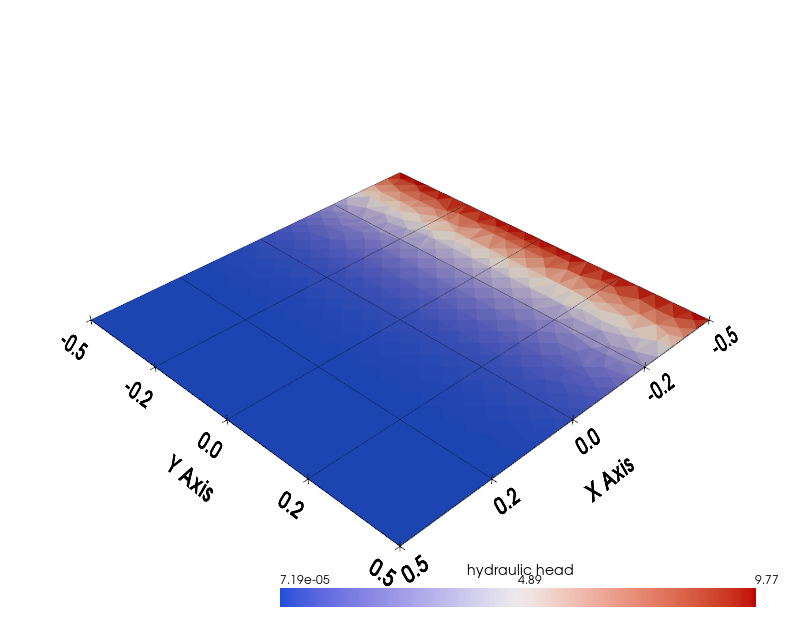

In [9]:
# Set the final time for the simulation (in seconds)
finalTime = 0.1
t = 0  # Initialize time

# Solve the Darcy problem at each time step
while t < finalTime:
    # Solve the Darcy problem for the current time step
    Flow.solveProblem(DarcyProblem)
    
    # Update the time by adding the time step
    t += timeStep

# Import a function to plot the mesh and hydraulic head distribution
from sources.functions import plot_mesh

# Define the folder to save the plot
pathFolder = os.getcwd() + "/Tmp"

# Plot the hydraulic head distribution in the mesh
plot_mesh(meshFnet, Flow.getHead(), "hydraulic head")


Next, we extend the simulation to a longer time period, solving the Darcy problem further in time. At each time step, we will save the results to a file for later analysis. This allows us to visualize how the hydraulic head evolves over a more extended period.


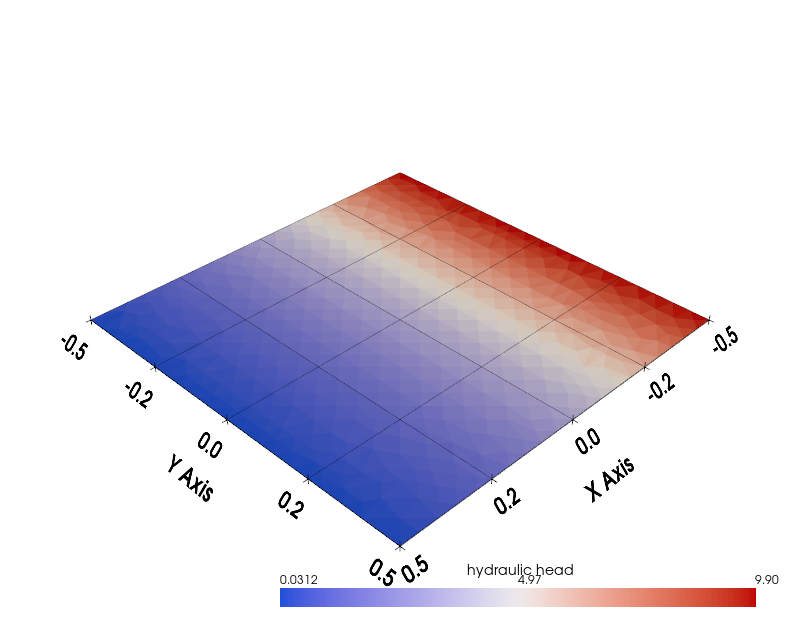

In [10]:
# Set the final time for the extended simulation (in seconds)
finalTime = 0.5

# Initialize an index for saving files
i = 0

# Import the IO module for saving flow results
import dfnlab.IO as io

# Solve the Darcy problem further in time, saving results at each time step
while t < finalTime:
    # Solve the Darcy problem for the current time step
    Flow.solveProblem(DarcyProblem)
    
    # Update the time
    t += timeStep
    
    # Save the current flow results to a file (for post-processing)
    io.write_flow_file(Flow, "Tmp/unsteady=" + str(i) + ".vtp")
    
    # Increment the file index
    i += 1

# Plot the hydraulic head distribution after the extended simulation
plot_mesh(meshFnet, Flow.getHead(), "hydraulic head")


#### Comparison with the Analytical Solution

The **analytical solution** for hydraulic head $ h^+(x^+, y^+, t^+) $ is given by the following series:

$
h^+(x^+,y^+,t^+) =  \left(\frac{l}{2}-x^+\right) + \frac{2}{\pi} \sum_{n=1}^{\infty} \frac{(-1)^n}{n} \sin\left(n \pi \left(\frac{l}{2}-x^+\right)\right) \exp\left(-\frac{(n\pi)^2t^+}{s p_0}\right)
$

Where:
- $ x^+ = \frac{x}{l}, y^+ = \frac{y}{l} $ are the normalized spatial coordinates.
- $ t^+ = \frac{tKh_0}{l^2} $ is the normalized time.
- $ h^+ = \frac{h}{h_0} $ is the normalized hydraulic head.
- $ l $ is the characteristic length of the system.
- $ K $ is the transmissivity, and \( p_0 \) is a pressure term.

We will compare the simulated values of hydraulic head from the DFN.Lab model with the theoretical values from this analytical solution to check the accuracy of the numerical method.


In [11]:
import numpy as np
import math as lm

# Define parameters for the analytical solution
alpha = 10  # Pressure term (same as initial hydraulic head)
s = 4       # Storativity
l = 1       # Characteristic length
K = 1       # Transmissivity
p0 = alpha  # Pressure term (same as alpha)
Tstar = l**2 / (K * p0)  # Time scaling factor

# Use the final simulation time from the previous section
T = t  

# Set the number of terms for the analytical solution's summation
n_terms = 100

# Initialize the error accumulator
error = 0

# Get the hydraulic head values from the simulation
hydraulicHead = Flow.getHead()

# Loop over all triangles in the mesh
for elem in range(meshFnet.numTriangles()):
    triangle = meshFnet.getTriangle(elem)
    
    # Get the barycenter of the triangle (position in space)
    position = triangle.getBarycenter()
    
    # Get the hydraulic head value from the simulation
    hh = hydraulicHead.val(triangle)
    
    if hh is not None:  # Ensure there is a valid hydraulic head value
        h = hh / p0  # Normalize the simulated hydraulic head
        
        # Compute the analytical solution for this position
        posX = position[0]  # x-coordinate of the barycenter
        AnalyticSolution = alpha * (0.5 - posX / l)  # Initial term
        
        # Add the summation terms for the analytical solution
        for n in range(1, n_terms):
            AnalyticSolution += (2. * alpha / lm.pi) * ((-1) ** n / n) * \
                np.sin(n * lm.pi * (0.5 - posX / l)) * \
                np.exp(-(n * lm.pi) ** 2 * T / Tstar / (s * p0))
        
        AnalyticSolution /= p0  # Normalize the analytical solution
        
        # Compute the absolute error between the simulated and analytical results
        error += abs(h - AnalyticSolution)

# Compute the average error over all triangles
error /= meshFnet.numTriangles()

# Output the averaged absolute error
print(f"The averaged absolute error is: {error:.6f}")


The averaged absolute error is: 0.000945


### Learning Checkpoint: Example 1

At this point, you should be able to:
- Set up a simple unsteady flow simulation in a single fracture.
- Use the explicit Euler method to perform time-stepping in DFN.Lab.
- Compare numerical results with an analytical solution to evaluate accuracy.


---

### Example 2: 10 Fracture DFN with Doublet Test

In this example, we simulate a **doublet test** in a DFN containing 10 fractures. A doublet test involves pumping fluid from one borehole while injecting fluid into another. This test is used to evaluate the hydraulic connectivity of fractures between the boreholes.

We will begin by solving a **steady-state flow problem** with permeameter conditions applied to the DFN. After establishing the steady-state solution, we will simulate **pumping at a constant head** from the first borehole. After a certain time, we introduce an injection at the second borehole, creating an unsteady flow.

Let's start by solving the steady-state flow problem (with no actions in the wells).


solveDarcyProblem
1989
Linear system building 
Application of the boundary conditions
Linear System solving
compute the indicators


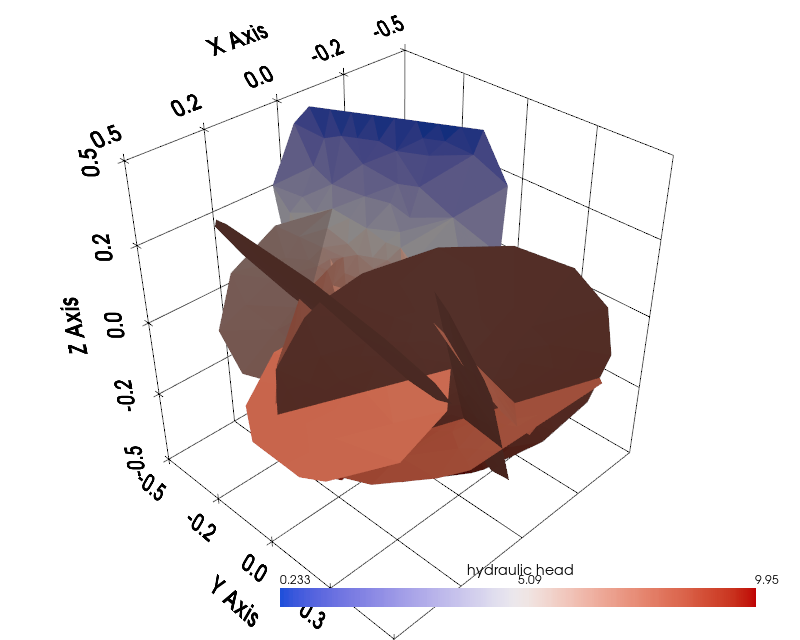

In [12]:
import dfnlab.System as sys
import dfnlab.Domains as dom
import dfnlab.Fractures as dfn
import dfnlab.FlowBoundaryConditions as bc
import dfnlab.Mesh as mesh 
import dfnlab.Flow as flow
import dfnlab.MaterialProperties as mat
import dfnlab.IO as io
import numpy as np
import os

# Initialize the DFN system and the domain
system = sys.System()
domain = dom.Domain()

# Build a cubic domain of size 1 m
system_size = 1
domain.buildParallelepiped(center=[0, 0, 0], L1=system_size)
system.setDomain(domain)

# Create two vertical wells for the doublet test
well1 = dom.Well1D([0.125, 0, -25], [0.125, 0, 25])  # Well 1
well2 = dom.Well1D([-0.25, 0, -25], [-0.25, 0, 25])  # Well 2

# Add the wells to the system
system.addGeometry(well1)
system.addGeometry(well2)

# Load the 10 fracture DFN from a disk file
fnet = dfn.DFN()
system.setDFN(fnet)
io.load_DFN_file(fnet, filename='sources/Ktest.disk', format="disk")

# Finalize the system setup
system.build()

# Create a mesh for the DFN
meshDFN = mesh.Mesh(system)
meshDFN.setCaracteristicLength(0.2)
meshDFN.setRefinementIntersection(3)
meshDFN.setGradationCoefficient(1.15)
meshDFN.generate()

# Apply permeameter boundary conditions (10 m hydraulic head difference) in the z-direction
h0 = 10
bc.FlowBoundaryCondition.setPermeameter(domain, h0, np.array([0, 0, 1]))

# Set transmissivity and storativity for the DFN
transmissivityValue = 1.0
transmissivities = mat.DFNProperties(fnet)
transmissivities.setConstant(transmissivityValue)
fnet.addProperties("transmissivities", transmissivities)

storativityValue = 4.0
storativities = mat.DFNProperties(fnet)
storativities.setConstant(storativityValue)
fnet.addProperties("storativities", storativities)

# Solve the steady-state Darcy problem
flow_system = flow.solveDarcyProblem(meshDFN)

# Plot the initial hydraulic head distribution
from sources.functions import *
pathFolder = os.getcwd() + "/Tmp"
plot_mesh(meshDFN, flow_system.getHead(), "hydraulic head")


The **steady-state flow solution** serves as the initial condition for the subsequent unsteady flow simulation. 

We now begin **pumping at a constant head** from the first borehole. This action introduces unsteady flow into the system, as water is extracted from the fracture network.


Time to build the linear system 7 s 


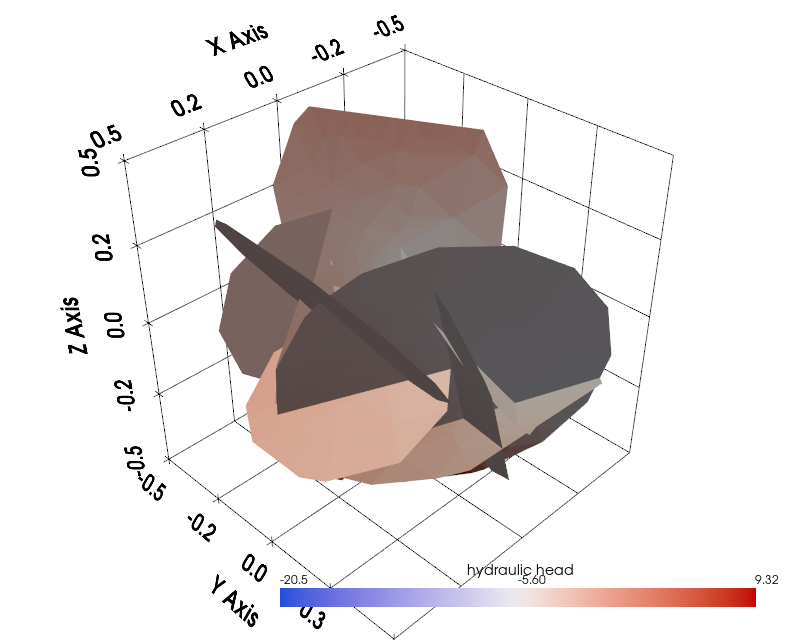

In [13]:
# Apply a constant head boundary condition (-20 m) to the first well (representing pumping)
bc.FlowBoundaryCondition.setHead(well2, -20)

# Initialize the time-stepping parameters for the unsteady simulation
t = 0
FinalTime1 = 20  # Simulate for 20 seconds
timeStep = 1     # Time step size of 1 second

# Create the Darcy problem for unsteady flow
DarcyProblem = flow.createDarcyProblem(flow_system, timeStep)

# Solve the unsteady flow problem at each time step
while t < FinalTime1:
    flow_system.solveProblem(DarcyProblem)
    t += timeStep

# Plot the hydraulic head distribution after pumping
plot_mesh(meshDFN, flow_system.getHead(), "hydraulic head")


Next, we begin **injection at the second borehole**, introducing fluid into the fracture network. This action creates a more complex unsteady flow, with both pumping and injection affecting the hydraulic


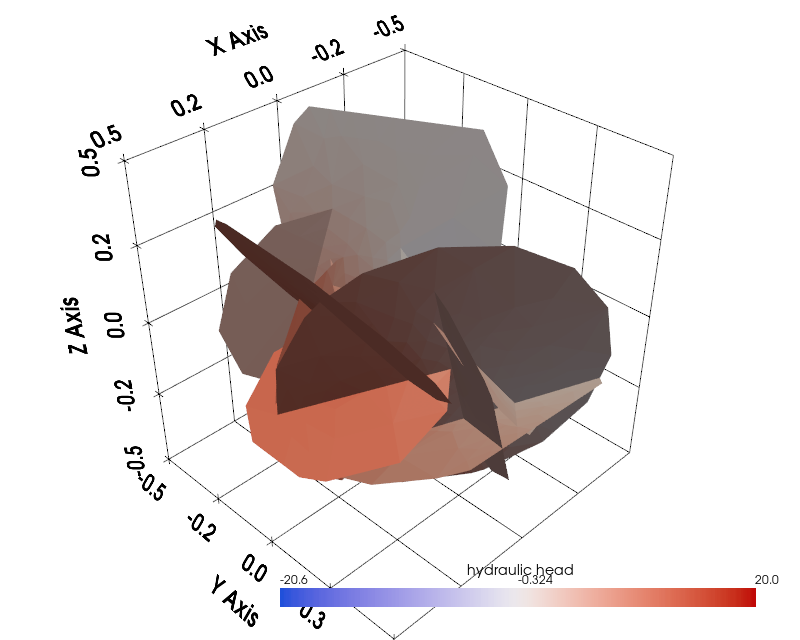

In [14]:
# Apply a constant head boundary condition (20 m) to the second well (representing injection)
bc.FlowBoundaryCondition.setHead(well1, 20)

# Extend the simulation for further unsteady flow analysis
FinalTime2 = 200  # Simulate for 200 seconds

# Ensure boundary conditions are correctly set for the new problem
meshDFN.setBoundaryCondition()

# Continue solving the unsteady flow problem after injection starts
while t < FinalTime2:
    flow_system.solveProblem(DarcyProblem)
    t += timeStep

# Plot the hydraulic head distribution after injection
plot_mesh(meshDFN, flow_system.getHead(), "hydraulic head")


To test the **convergence** of the unsteady flow solution, we compare it with the steady-state solution obtained after both **pumping and injection**. 

If the unsteady solution converges over time, it should approach the steady-state solution, meaning the hydraulic head distribution will stabilize.


solveDarcyProblem
1989
Linear system building 
Application of the boundary conditions
Linear System solving
compute the indicators


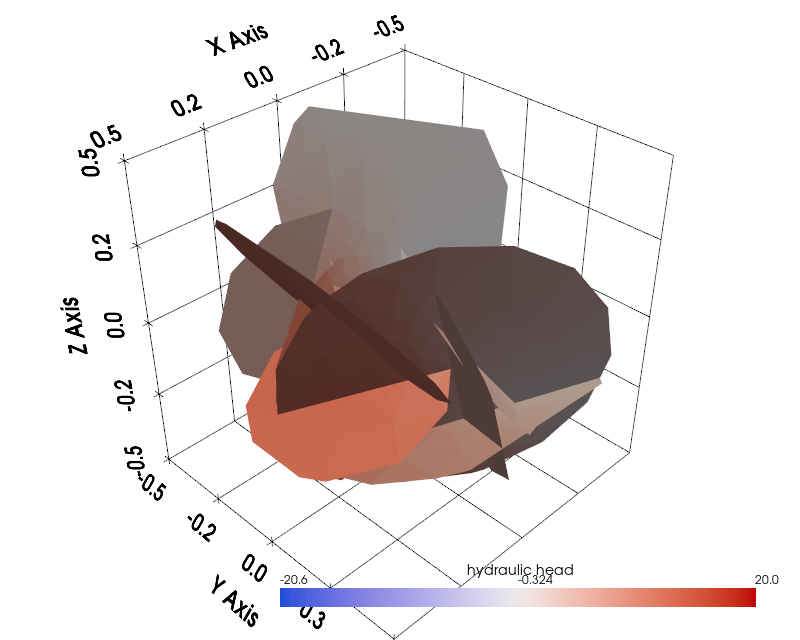

1020


In [15]:
# Solve the steady-state Darcy problem (after pumping and injection)
steadyStateFlowSystem = flow.solveDarcyProblem(meshDFN)

# Plot the hydraulic head distribution for the steady-state solution
plot_mesh(meshDFN, steadyStateFlowSystem.getHead(), "hydraulic head")

# Print the number of triangles in the mesh
print(meshFnet.numTriangles())


We now compute the **difference** between the hydraulic head values of the unsteady flow solution and the steady-state solution. This difference provides a measure of how closely the unsteady flow has converged to the steady-state solution.


In [16]:
# Retrieve the hydraulic head values from the unsteady and steady-state solutions
unSteadyH = flow_system.getHead()
steadyH = steadyStateFlowSystem.getHead()

# Initialize the error accumulator
error = 0

# Loop over all triangles in the mesh to compute the difference
for elem in range(meshDFN.numTriangles()):
    triangle = meshDFN.getTriangle(elem)
    
    # Get the hydraulic head values for the current triangle
    h1 = unSteadyH.val(triangle)  # Unsteady solution
    h2 = steadyH.val(triangle)    # Steady-state solution
    
    # Ensure both values exist before computing the difference
    if h1 is not None and h2 is not None:
        # Accumulate the absolute difference, weighted by the triangle's area
        error += abs(h1 - h2) * triangle.getArea()
    else:
        print("Error: Missing hydraulic head value for triangle.")
        
# Output the total difference between the unsteady and steady-state solutions
print(f"Difference between converged unsteady solution and steady-state solution: {error:.6f}")


Difference between converged unsteady solution and steady-state solution: 0.000000


## Optional Exercises

Now that you've completed the tutorial, here are a few optional exercises to deepen your understanding:

1. **Vary the Time Step Size**:
   - Try changing the time step size ($ \Delta t $) in the unsteady flow simulations and observe how it affects the results. Can you find a time step size that leads to more accurate results without making the simulation too slow?

2. **Modify Transmissivity and Storativity**:
   - Experiment with different values for transmissivity and storativity. For example, set the storativity to 0 (representing incompressible flow) and see how it changes the system's behavior.

3. **Visualize Flow Vectors**:
   - In addition to visualizing hydraulic head, try plotting **flow vectors** (Darcy velocity) to see how fluid moves through the fractures. This can provide additional insight into flow dynamics.

4. **Custom DFN**:
   - Modify the input DFN file to create your own fracture network. Use DFN.Lab to simulate flow in your custom DFN and observe how different fracture configurations affect flow patterns.

## Final Summary

In this tutorial, you've learned how to:
- Simulate unsteady flow in simple and complex DFNs.
- Apply boundary conditions such as permeameter conditions and constant head pumping.
- Use the explicit Euler method for time-stepping in unsteady flow simulations.
- Compare numerical results with both analytical and steady-state solutions to evaluate convergence and accuracy.

### What's Next?

To further expand your understanding of DFN modeling, you may want to explore:
- **Advanced boundary conditions**: Learn how to apply more complex boundary conditions such as flux or time-varying head conditions.
- **3D DFN modeling**: Dive into more advanced simulations where fluid flow is modeled in three-dimensional fracture networks.
- **DFN fracture mechanics**: Combine flow simulations with mechanical simulations to analyze how fractures respond to stress and pressure changes.

Check out the DFN.Lab documentation for more tutorials and advanced examples.
